In [ ]:
!pip install -U tensorflow_datasets

In [ ]:
import tensorflow as tf

# Importing Tensorflow datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper Libraries
import math
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
# Loading Fashion MNIST data and spitting into train and test data
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Since each image is mapped to a single label. We are saving the class names for plotting the graphs.
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [ ]:
# EDA of data beforing training model

num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [ ]:
# The value of each pixel in the image data is an integer in the range [0,255].
# For the model to work properly, these values need to be normalized to the range [0,1].
# So here we create a normalization function, and then apply it to each image in the test and train datasets.

def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

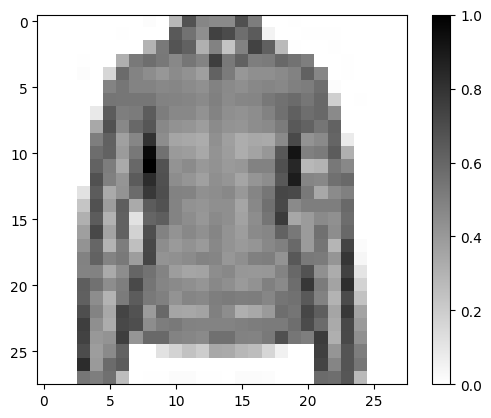

In [ ]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

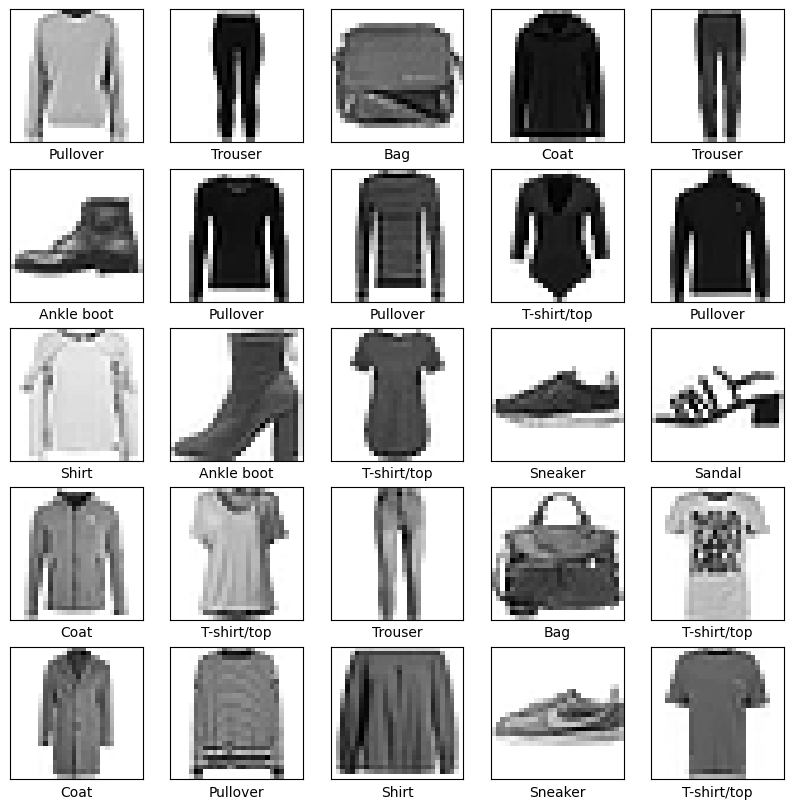

In [ ]:
# Display the first 25 images from the training set and display the class name below each image.
# Verify that the data is in the correct format and we're ready to build and train the network.

plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_dataset.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

In [ ]:
# Building a Dense Network
# Setting up the Dense Layer
    # Output Layer : A 128-neuron, followed by 10-node softmax layer. Each node represents a class of clothing.
    # As in the previous layer, the final layer takes input from the 128 nodes in the layer before it,
    # and outputs a value in the range [0, 1], representing the probability that the image belongs to that class.
    # The sum of all 10 node values is 1

model = tf.keras.Sequential([
    # Input Layer - Flattened from 2D to a Vector
    # input shape: 28 pixels length * 28 pixels width  * 1 color channel(i.e. grayscale)
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    # Hidden Layer
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    # Output Layer
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [ ]:
# Compiling Model
  ## Loss function — An algorithm for measuring how far the model's outputs are from the desired output.
  ## The goal of training is this measures loss.

  ## Optimizer —An algorithm for adjusting the inner parameters of the model in order to minimize loss.

  ## Metrics —Used to monitor the training and testing steps.
  ## The following example uses accuracy, the fraction of the images that are correctly classified.

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Training the Dataset
  ## Parameters:
  ## 1. dataset.repeat() - repeat for number of epochs
  ## 2. dataset.shuffle() - set it to train data length so that the model cannot learn from examples
  ## 3. dataset.batch() - tell the model to use batches of images and labels when updating model variables
  ## 4. dataset.cache() - After the dataset is loaded once from disk, it keeps it in memory to make training faster

BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [ ]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 9s 2ms/step - loss: 0.4943 - accuracy: 0.8271
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3764 - accuracy: 0.8642
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3361 - accuracy: 0.8782
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3106 - accuracy: 0.8866
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2938 - accuracy: 0.8924


In [ ]:
# Evaluating Accuracy on Test Data
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 2s 5ms/step - loss: 0.3474 - accuracy: 0.8750
Accuracy on test dataset: 0.875


In [ ]:
# Now that the model is evaluated on test data.
# We will make predictions and explore the results

for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 [==============================] - 0s 79ms/step


In [ ]:
# Checking the shape of prediction
predictions.shape

(32, 10)

In [ ]:
# Taking a look at the first prediction result based on test data
# We get an array of 10 numbers that depicts the confidence of the model
# for predicting the image against each label.

predictions[0]

array([2.1042286e-05, 1.6668707e-07, 1.0067647e-02, 4.4364756e-07,
       9.4971961e-01, 2.3469660e-09, 4.0168371e-02, 2.9966024e-10,
       2.2686461e-05, 1.0301028e-08], dtype=float32)

In [ ]:
# finding the label with highest confidence

np.argmax(predictions[0])

4

In [ ]:
# Checking test label based on confidence

test_labels[0]

4

In [ ]:
# Graph for full set of 10 class predictions

def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

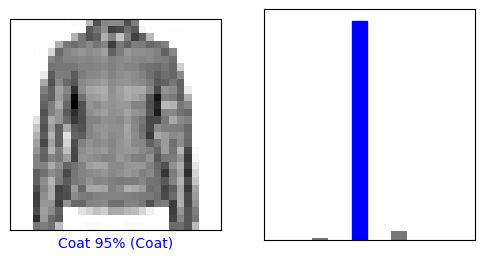

In [ ]:
# Looking at )th image, prediction and predictiing array
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

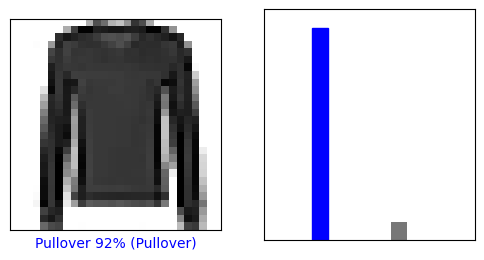

In [ ]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

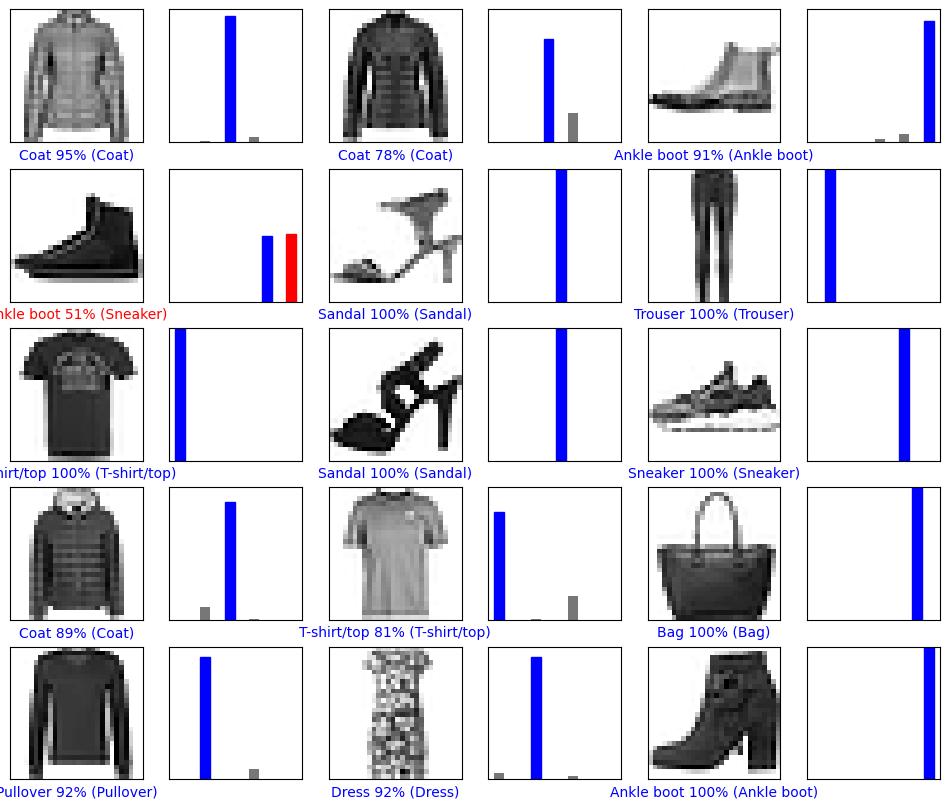

In [ ]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [ ]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [ ]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [ ]:
# Prediction the single image

predictions_single = model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 40ms/step
[[2.10423059e-05 1.66687087e-07 1.00676538e-02 4.43647593e-07
  9.49719667e-01 2.34698416e-09 4.01684307e-02 2.99660824e-10
  2.26864413e-05 1.03010285e-08]]


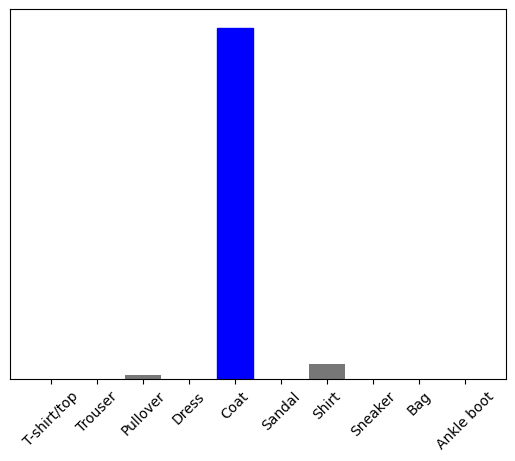

In [ ]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [ ]:
np.argmax(predictions_single[0])

4